In [1]:
import sys
sys.path.append('../')

In [4]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
from scripts.utils.data_loading import load_data

In [26]:
pd.set_option('display.max_rows', 500)
%matplotlib inline

In [82]:
DATA_DIRECTORY = '../data/limit-order-book/XXRPZUSD'

In [83]:
start = datetime(2020, 2, 9, 22, 1, 0)
end = datetime(2020, 2, 9, 23, 1, 0)  # 2020-02-10 06:18:43

In [84]:
df = load_data(DATA_DIRECTORY, start, end)

2it [00:00, 12.31it/s]


In [85]:
df['query_datetime'] = pd.to_datetime(df['query_time'], unit='s')

In [86]:
for ts, grp in df.groupby('query_datetime'):
    print(grp.head(10))
    break

     price     volume   timestamp type    query_time  \
0  0.27731    107.000  1581313779    a  1.581314e+09   
1  0.27736   4133.999  1581313781    a  1.581314e+09   
2  0.27740   4999.990  1581313782    a  1.581314e+09   
3  0.27741  81100.000  1581313774    a  1.581314e+09   
4  0.27745   1101.547  1581313782    a  1.581314e+09   
5  0.27746  16935.119  1581313775    a  1.581314e+09   
6  0.27750   5000.000  1581313781    a  1.581314e+09   
7  0.27752   7210.000  1581313782    a  1.581314e+09   
8  0.27759   7522.441  1581313781    a  1.581314e+09   
9  0.27762  10061.000  1581313780    a  1.581314e+09   

                 query_datetime  
0 2020-02-10 05:49:42.747158289  
1 2020-02-10 05:49:42.747158289  
2 2020-02-10 05:49:42.747158289  
3 2020-02-10 05:49:42.747158289  
4 2020-02-10 05:49:42.747158289  
5 2020-02-10 05:49:42.747158289  
6 2020-02-10 05:49:42.747158289  
7 2020-02-10 05:49:42.747158289  
8 2020-02-10 05:49:42.747158289  
9 2020-02-10 05:49:42.747158289  


In [87]:
timeseries, midpriceseries, spreadseries = [], [], []
sell_array = []
for ts, grp in df.groupby('query_datetime'):
    minask = grp.loc[grp['type'] == 'a', 'price'].min()
    maxbid = grp.loc[grp['type'] == 'b', 'price'].max()
    midprice = (minask + maxbid) / 2
    spread = minask - maxbid
    midprice = (minask + maxbid) / 2
    grp['relprice'] = 100 * (grp['price'] - midprice) / midprice
    grp = grp[((grp['relprice'] < 1) & (grp['type'] == 'a')) | ((grp['relprice'] > -1) & (grp['type'] == 'b'))]
#     print(grp)
#     print((grp[grp['type'] == 'a'].volume * grp[grp['type'] == 'a'].price).sum())
    sell_array.append((grp[grp['type'] == 'b'].volume * grp[grp['type'] == 'b'].price).sum())
    liquidity_data[DATA_DIRECTORY] = np.mean(sell_array[::10])
#     break
#     timeseries.append(ts)
#     midpriceseries.append(midprice)
#     spreadseries.append(spread)

/home/maxlamberti/anaconda3/envs/AFP_ENV/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [88]:
liquidity_data

{'../data/limit-order-book/USDTZUSD': 833751.3249249526,
 '../data/limit-order-book/XETHZUSD': 559673.2543222535,
 '../data/limit-order-book/XREPZUSD': 11682.529258578652,
 '../data/limit-order-book/XXBTZUSD': 1950557.0169042018,
 '../data/limit-order-book/XXMRZUSD': 92625.63343691011,
 '../data/limit-order-book/XXRPZUSD': 189830.8252806956}

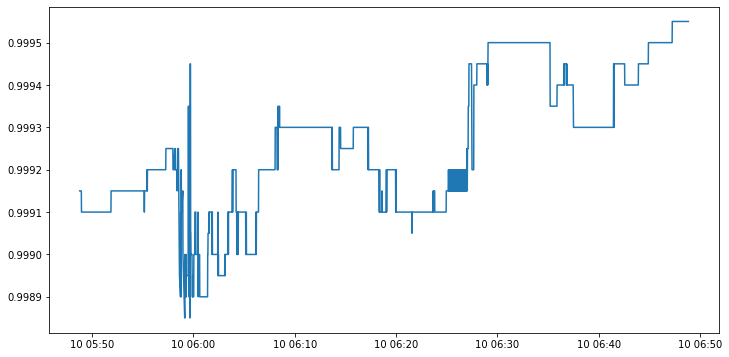

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(timeseries, midpriceseries);

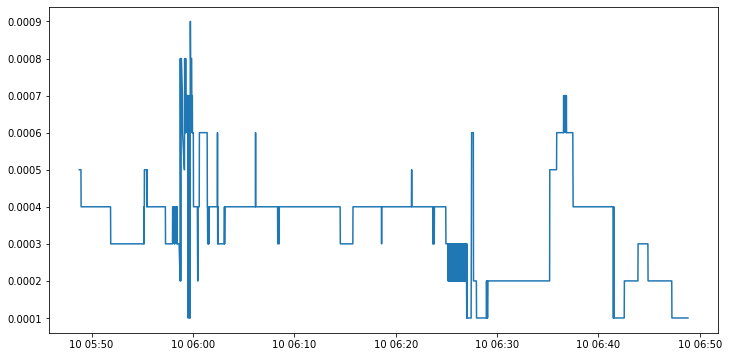

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(timeseries, spreadseries);

(array([ 13.,   1.,  26.,  20.,  29., 117.,  32.,  46.,  49.,  23.]),
 array([737688.5740461 , 754075.53466894, 770462.49529178, 786849.45591462,
        803236.41653746, 819623.3771603 , 836010.33778314, 852397.29840598,
        868784.25902882, 885171.21965166, 901558.1802745 ]),
 <a list of 10 Patch objects>)

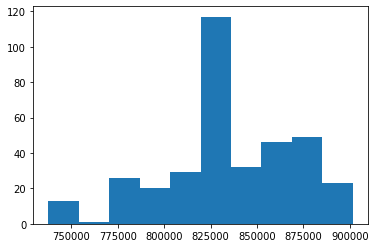

In [43]:
plt.hist(sell_array[::10])

In [44]:
np.mean(sell_array[::10])

833751.3249249526

In [104]:
l_data, l_label = [], []
for k, v in liquidity_data.items():
    print(k.split('/')[-1], v)
    l_data.append(v)
    l_label.append(k.split('/')[-1])
    
l_df = pd.DataFrame({'pair': l_label, 'liquidity': l_data})

USDTZUSD 833751.3249249526
XETHZUSD 559673.2543222535
XREPZUSD 11682.529258578652
XXBTZUSD 1950557.0169042018
XXMRZUSD 92625.63343691011
XXRPZUSD 189830.8252806956


In [115]:
l_df.sort_values('liquidity', inplace=True, ascending=False)
l_df['log_liquidity'] = np.log(l_df['liquidity'])

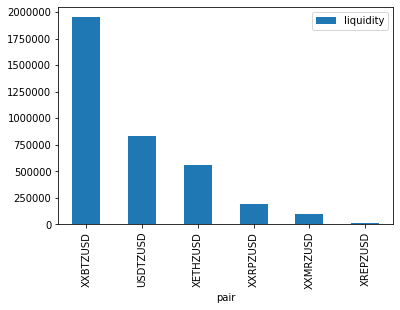

In [125]:
l_df.plot(y='liquidity', kind='bar', x='pair')
plt.legend()

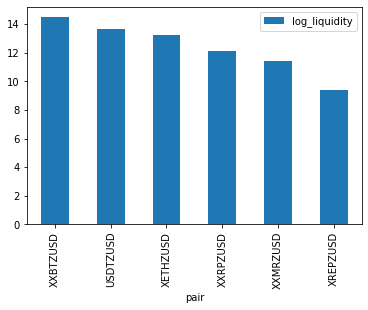

In [117]:
l_df.plot(y='log_liquidity', kind='bar', x='pair')

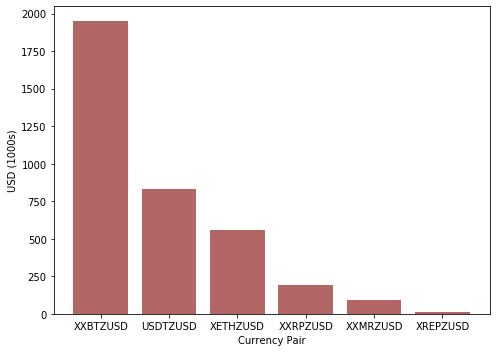

In [149]:
plt.figure(figsize=(7, 5))
plt.bar(l_df.pair, l_df.liquidity / 1000, color='maroon', alpha=0.6)
plt.xlabel("Currency Pair")
plt.ylabel("USD (1000s)")
plt.tight_layout()
plt.savefig('/home/maxlamberti/Desktop/Liquidity_Depth.png', dpi=400);